<a href="https://colab.research.google.com/github/Yshen-11/DUKE_XAI/blob/main/assignment7/Assignment7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Impact of Background on Image Classification
## Saliency Map Visualization with PyTorch and ResNet-50

This notebook demonstrates how to generate and visualize saliency maps using a pre-trained ResNet-50 model in PyTorch. Saliency maps highlight the parts of an image that the model considers important for its predictions, helping us understand the model's focus when making classification decisions. This process is often used in Explainable AI to reveal which features are most influential in the model's predictions.

### Step 1: Import Libraries and Load Pre-trained Model
We start by importing the necessary libraries and loading the ResNet-50 model, which is pre-trained on ImageNet. This model will be used to make predictions and generate saliency maps for various images.

The ImageNet labels are also loaded to interpret the model's predictions.



In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import requests
from io import BytesIO
import json
import matplotlib.pyplot as plt
import numpy as np

# Load pre-trained ResNet-50 model
model = models.resnet50(pretrained=True)
model.eval()  # Set to evaluation mode

# Define image preprocessing steps
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load ImageNet labels
LABELS_PATH = 'https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json'
labels = json.loads(requests.get(LABELS_PATH).text)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 113MB/s]


### Step 2: Image Preprocessing
To feed images into ResNet-50, we need to preprocess them to match the model's input requirements. This includes resizing, cropping, converting to tensor format, and normalizing the pixel values.

The load_image_from_url function allows us to load and preprocess images directly from URLs.

In [ ]:
# Helper function to load and preprocess images
def load_image_from_url(img_url):
    response = requests.get(img_url)
    image = Image.open(BytesIO(response.content)).convert("RGB")
    return preprocess(image).unsqueeze(0)  # Add batch dimension

### Step 3: Generate Saliency Map

Using the gradient of the model's prediction with respect to the input image, we can compute a saliency map. This map highlights the areas in the image that most influence the model's top prediction.

The `generate_saliency_map` function calculates the saliency by finding the maximum gradient values across color channels, resulting in a grayscale map that shows regions of interest.

In [ ]:
# Saliency map generation function
def generate_saliency_map(model, img_tensor):
    img_tensor.requires_grad_()  # Enable gradients
    outputs = model(img_tensor)
    _, predicted_class = outputs.max(1)  # Get predicted class
    score = outputs[0, predicted_class]  # Get score for predicted class
    score.backward()  # Backpropagate to get gradients

    # Compute saliency by taking the maximum absolute value across channels
    saliency, _ = torch.max(img_tensor.grad.data.abs(), dim=1)
    return saliency.squeeze().numpy(), predicted_class.item()

### Step 4: Unified Experiment Function

The `run_saliency_experiment` function is a unified function that takes an image URL, generates the saliency map, and displays the original image along with the predicted label and the saliency map. This function allows us to test different images under various conditions and view the results in a single, consistent format.

In [ ]:
# Unified function for running saliency map experiments
def run_saliency_experiment(img_url, model, labels, title="Saliency Map"):
    # Load and preprocess the image
    img_tensor = load_image_from_url(img_url)

    # Generate saliency map and prediction
    saliency, top_class = generate_saliency_map(model, img_tensor)
    prediction_label = labels[top_class]
    print(f"Prediction for {title}: {prediction_label}")

    # Load original image for display
    response = requests.get(img_url)
    img = Image.open(BytesIO(response.content)).convert("RGB")

    # Plot original image, prediction, and saliency map
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(img)
    ax1.axis('off')
    ax1.set_title(f"Prediction: {prediction_label}")

    ax2.imshow(saliency, cmap='hot')
    ax2.axis('off')
    ax2.set_title(title)
    plt.show()

### Step 5: Run Saliency Experiments

We run the `run_saliency_experiment` function on four different images to observe how the model’s predictions and saliency maps change under different conditions:
1. **Baseline (Original Image)** - The original image without any modifications.
2. **Occluded Background** - The background of the image is removed to see if it affects the model’s focus.
3. **Occluded Main Object** - The main object is occluded, testing how the model responds to missing key features.
4. **Replaced Background** - The background is replaced with a different image to observe any changes in model behavior.

Each experiment provides insights into how background and foreground elements impact the model's prediction and saliency.

Prediction for Baseline (Original Image) Saliency Map: American Staffordshire Terrier


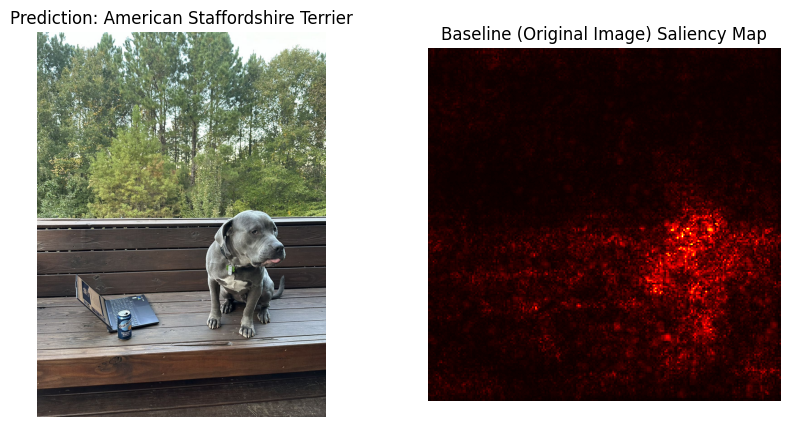

Prediction for Occluded Background Saliency Map: American Staffordshire Terrier


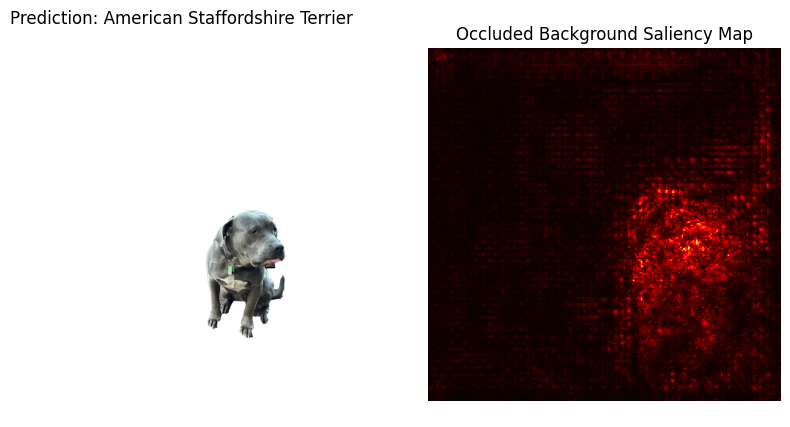

Prediction for Occluded Main Object Saliency Map: crate


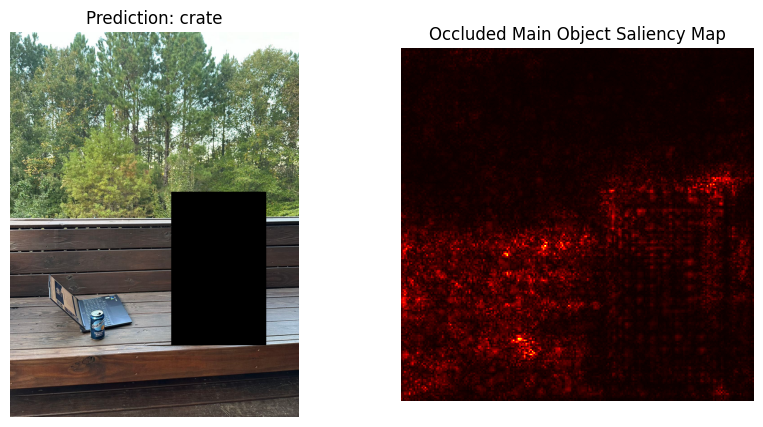

Prediction for Replaced Background Saliency Map: Weimaraner


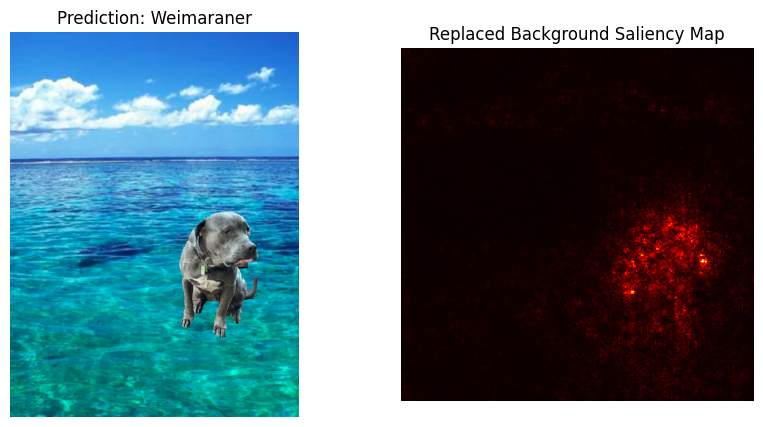

In [ ]:
# Run baseline image experiment
run_saliency_experiment("https://github.com/Yshen-11/DUKE_XAI/raw/main/assignment7/blu.jpg", model, labels, "Baseline (Original Image) Saliency Map")

# Run occluded background image experiment
run_saliency_experiment("https://github.com/Yshen-11/DUKE_XAI/raw/main/assignment7/blu-removeback.png", model, labels, "Occluded Background Saliency Map")

# Run occluded main object image experiment
run_saliency_experiment("https://github.com/Yshen-11/DUKE_XAI/raw/main/assignment7/blu-covermain.png", model, labels, "Occluded Main Object Saliency Map")

# Run replaced background image experiment
run_saliency_experiment("https://github.com/Yshen-11/DUKE_XAI/raw/main/assignment7/blu-replaceback.png", model, labels, "Replaced Background Saliency Map")

Based on the saliency map visualization results in each scenario, here’s an analysis of how background and foreground modifications affect the model’s predictions and focus areas:

1. **Baseline (Original Image):**
   - **Prediction:** American Staffordshire Terrier
   - **Saliency Map:** The model correctly focuses on the dog, particularly the head and face areas, which are crucial for identifying dog breeds. The background has minimal influence on the model’s attention.
   - **Interpretation:** In an unaltered image, the model performs as expected, highlighting the features most relevant to the breed's identification.

2. **Occluded Background:**
   - **Prediction:** American Staffordshire Terrier
   - **Saliency Map:** With the background removed, the model still successfully predicts the same breed and focuses on the dog’s body, especially the face. This suggests that the model’s prediction does not heavily rely on the background for identifying the object.
   - **Interpretation:** The model appears robust to background removal, showing that it primarily relies on the main object (the dog) to make accurate predictions.

3. **Occluded Main Object:**
   - **Prediction:** Crate
   - **Saliency Map:** With the dog partially obscured, the model incorrectly predicts "crate." The saliency map shows that the model is focusing on the remaining visible parts of the image, which might include background textures or shapes resembling a crate.
   - **Interpretation:** This occlusion disrupts the model's ability to recognize the dog, leading it to rely on other features in the image, such as the shape and structure in the blacked-out area, resulting in an incorrect classification. It indicates that the model is sensitive to occlusion of key object parts.

4. **Replaced Background:**
   - **Prediction:** Weimaraner
   - **Saliency Map:** With the background replaced, the model predicts "Weimaraner" instead of "American Staffordshire Terrier." The saliency map still focuses on the dog, particularly the head, but the prediction changes, potentially due to contextual clues from the new background (ocean).
   - **Interpretation:** The change in background affects the model's interpretation, possibly due to associations between Weimaraners and outdoor/water-related imagery. This suggests that, while the model focuses on the object itself, background context can sometimes influence predictions.

### Summary:
- The model accurately identifies the breed when the background is removed, showing that it primarily relies on object features for classification.
- Occluding the main object confuses the model, leading to misclassification, which highlights its reliance on key object features.
- Replacing the background can alter the prediction, implying that the model sometimes considers context or associates certain backgrounds with specific breeds.